In [1]:
import tensorflow as tf
import numpy as np
import random
import time  
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import scipy.io as scp
import sklearn as skl
import  urllib.request as urlreq
import random
from IPython.display import display, Image
import tarfile
from datetime import datetime
from six.moves import cPickle as pickle
%matplotlib inline
print ("Tensor flow version is -- ", tf.__version__)
tf.test.is_gpu_available()

Tensor flow version is --  1.0.0


True

In [2]:
# downloading the data

url = 'http://ufldl.stanford.edu/housenumbers/'
prefix      =   "mat/" 
last_percent_reported = None

def progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, force=False): 
    if force or not os.path.exists(prefix+filename):
        print('Attempting to download:', filename) 
        filename, _ = urlreq.urlretrieve(url+filename, prefix+filename, reporthook=progress_hook)
        print('\nDownload Complete!, file present at ', filename) 
        statinfo = os.stat(filename)
    else:
        filename = prefix+filename
        print('Not downloading, file already present at ', filename) 
    
    return filename


test_file  = maybe_download('test.tar.gz')
train_file = maybe_download('train.tar.gz')
extra_file = maybe_download('extra.tar.gz')  

Not downloading, file already present at  mat/test.tar.gz
Not downloading, file already present at  mat/train.tar.gz
Not downloading, file already present at  mat/extra.tar.gz


In [3]:
# extract tar files to folders

np.random.seed(99)

def maybe_extract(filename, force=False):
    
    if filename.endswith('tar.gz'):
        root = filename.split('/')[0]
        folder = (filename.split('/')[1]).split('.')[0]
        pathtofolder = root+'/'+folder 
        if os.path.isdir(pathtofolder) and not force:
            print('%s already present - Skipping extraction of %s' % (root, filename))
            return pathtofolder+'/'
        else:
            print('Extracting data to  %s ....' % pathtofolder)
            tar = tarfile.open(filename, "r:gz") 
            tar.extractall(path = root)
            tar.close()
            data_folders = root 
            return pathtofolder+'/'
    else:
        print ('The tar gzipped file ', filename, ' does not exist. Download it first.')
    
  
train_folders = maybe_extract(train_file)
test_folders  = maybe_extract(test_file)
extra_folders = maybe_extract(extra_file)

mat already present - Skipping extraction of mat/train.tar.gz
mat already present - Skipping extraction of mat/test.tar.gz
mat already present - Skipping extraction of mat/extra.tar.gz


In [4]:
# Source http://www.a2ialab.com/

# SVHN extracts data from the digitStruct.mat full numbers files.   
#
# This is an A2iA tweak (YG -9 Jan 2014) of the script found here :
# http://blog.grimwisdom.com/python/street-view-house-numbers-svhn-and-octave
#
# The digitStruct.mat files in the full numbers tars (train.tar.gz, test.tar.gz, and extra.tar.gz) 
# are only compatible with matlab.

import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
    
     
dsf = DigitStructFile( train_folders + 'digitStruct.mat')
train_data = dsf.getAllDigitStructure_ByDigit()
print ( len(train_data) )

fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()
print (len(test_data))

fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()
print (len(extra_data))

33402
13068
202353


In [5]:
# Adapted from https://github.com/hangyao/
import PIL.Image

def img2dataset(data, folder):
    #define arrays to store image data
    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    # create array to store length and 5 digits in vector of length 6
    label = np.ones([len(data),6], dtype=int) * 10
    #loop over all images and store 
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        path = os.path.join(folder, filename)
        img =  PIL.Image.open(path)
        boxes = data[i]['boxes']
        digitcount = len(boxes)
        label[i,0] = digitcount
        top = np.ndarray([digitcount], dtype='float32')
        left = np.ndarray([digitcount], dtype='float32')
        height = np.ndarray([digitcount], dtype='float32')
        width = np.ndarray([digitcount], dtype='float32')
        for j in np.arange(digitcount):
            if j < 5: 
                label[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: label[i,j+1] = 0
            else: print('image',i,'ignored as too long (>5 digits).')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        # measuring out which box is the highest/most left plus height and width
        img_top = np.amin(top)
        img_left = np.amin(left)
        img_height = np.amax(top) + height[np.argmax(top)] - img_top
        img_width = np.amax(left) + width[np.argmax(left)] - img_left
        
        #calculating cut off region
        img_top = np.floor(img_top - 0.1 * img_height)
        img_left = np.floor(img_left - 0.1 * img_width)
        img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), img.size[1]])
        img_right = np.amin([np.ceil(img_left + 1.2 * img_width), img.size[0]])
        
        
        # crop and resize to create image of size 32x32 with all digits in it
        img = img.crop((img_left, img_top, img_right, img_bottom)).resize([32,32],  PIL.Image.ANTIALIAS)
        
        #converting to grayscale
        img = np.dot(np.array(img, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        
        # normalizing
        mean = np.mean(img, dtype='float32')
        std = np.std(img, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        img = (img - mean) / std
        
        dataset[i,:,:,:] = img[:,:,:]
        
    return dataset, label

train_dataset1, train_labels1 = img2dataset(train_data, train_folders)
print(train_dataset1.shape, train_labels1.shape)

test_dataset, test_labels = img2dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = img2dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)

image 29929 ignored as too long (>5 digits).
(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)
(202353, 32, 32, 1) (202353, 6)


In [6]:

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0]) 
    return dataset[permutation,:,:], labels[permutation] 

 
total_dataset = np.concatenate((train_dataset1,extra_dataset), axis=0)
total_labels  = np.concatenate((train_labels1,extra_labels), axis=0) 

print(total_dataset.shape, total_labels.shape)


total_dataset, total_labels = randomize(total_dataset, total_labels)

print(total_dataset.shape, total_labels.shape)

valid_size = 5755


(235755, 32, 32, 1) (235755, 6)
(235755, 32, 32, 1) (235755, 6)


(230000, 32, 32, 1) (230000, 6)
(5755, 32, 32, 1) (5755, 6)
(13068, 32, 32, 1) (13068, 6)


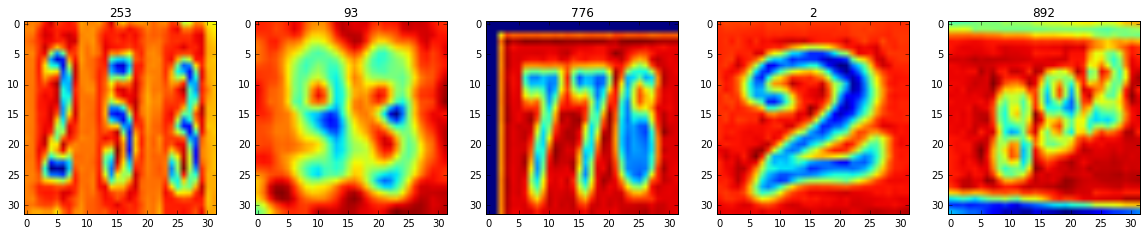

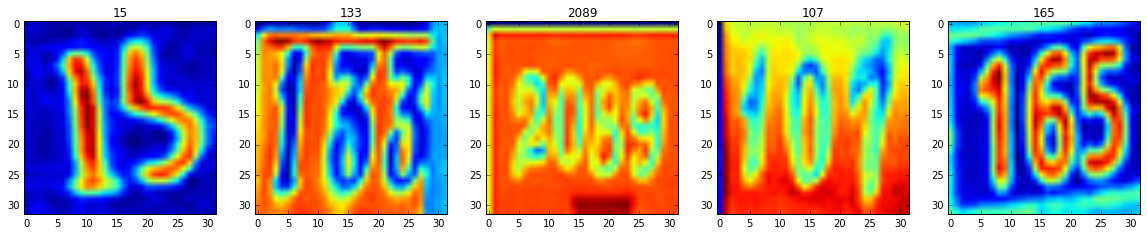

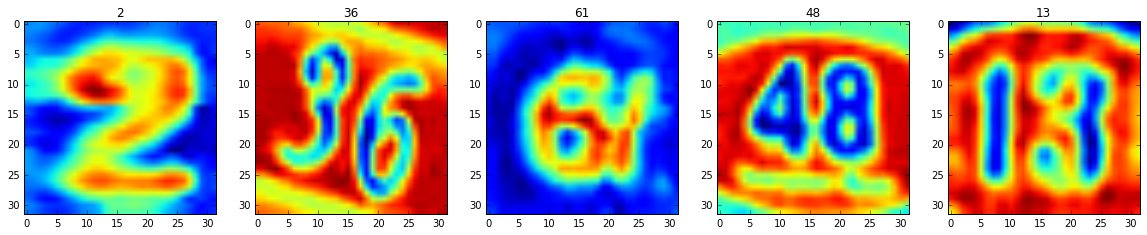

In [7]:

train_dataset   = total_dataset[:-valid_size,:,:,:]
train_labels    = total_labels[:-valid_size,:] 

valid_dataset   = total_dataset[-valid_size:,:,:]
valid_labels    = total_labels[-valid_size:,:] 

print(train_dataset.shape, train_labels.shape) 
print(valid_dataset.shape, valid_labels.shape)
print(test_dataset.shape, test_labels.shape) 
 

def showgreyscale(data, label): 
    fig=plt.figure(1,figsize=(20, 10))
    size=5
    l=np.random.randint(0,len(label),size) 
    for i in range(1,6,1):
        plt.subplot(1,5,i) 
        plt.title(label[l[i-1] ], loc='center')
        plt.imshow(data[ l[i-1] ,:,:])
    plt.show()
    plt.close(fig)
        
def arraytonum(arr): 
    ret = np.zeros(arr.shape[0],dtype=int) 
    
    for i in range(arr.shape[0]):
        a=0
        for j in range(6):
            if  arr[i,j] == 10 or j == 0:
                continue
            a = 10*a+arr[i,j]  
        ret[i] = a

    return ret


showgreyscale(train_dataset[:,:,:,0], arraytonum(train_labels) )
showgreyscale(valid_dataset[:,:,:,0], arraytonum(valid_labels) )
showgreyscale(test_dataset[:,:,:,0], arraytonum(test_labels) )



In [8]:
# create pickle file for later use
pickle_file = 'multi_image_cnn.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,    
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031123048
